### Attribute Information
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

## Information from image , just for understanding the dataset

#### Source of image 1: https://my.clevelandclinic.org/health/diseases/21489-angina

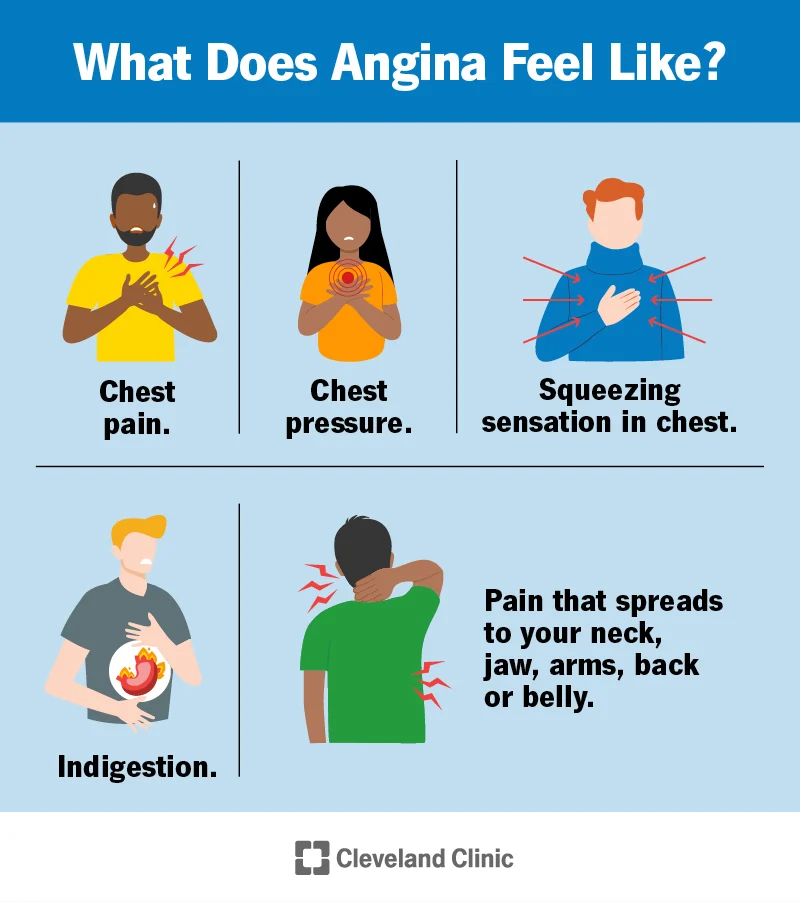

#### Source of image 2: https://theheartfoundation.org/2018/10/05/blood-pressure/

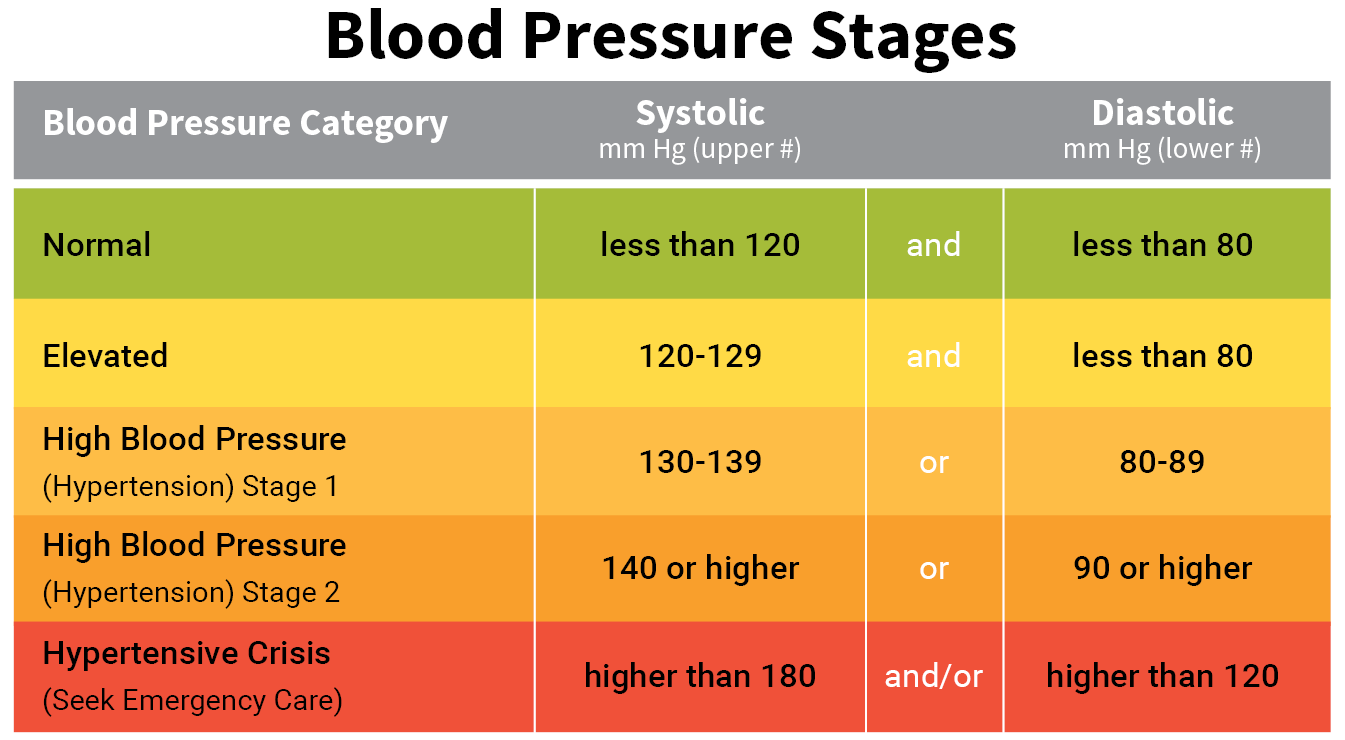

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

#### Data Intution and Cleaning

In [2]:
df=pd.read_csv('heart.csv')

In [3]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [4]:
df['FastingBS'].unique()

array([0, 1], dtype=int64)

In [5]:
df.shape

(918, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### All object or string columns

In [7]:
object_cols=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

#### Statistical Information about data

In [8]:
df.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

#### Checking for null values

In [9]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

#### Checking for duplicate values

In [10]:
df.duplicated().sum()

0

### Capping the outliers

In [11]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values above upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)

    # Cap values below lower bound
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)

#### Converting the categorical columns to Numerical columns

In [12]:
for col in object_cols:
    n=len(df[col].unique())
    values=df[col].unique()
    for i in range(n):
        df[col].replace({values[i]:i},inplace=True)

In [13]:
df.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0      140.0        289.0          0           0   
1   49    1              1      160.0        180.0          0           0   
2   37    0              0      130.0        283.0          0           1   
3   48    1              2      138.0        214.0          0           0   
4   54    0              1      150.0        195.0          0           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0  172.0               0      0.0         0             0  
1  156.0               0      1.0         1             1  
2   98.0               0      0.0         0             0  
3  108.0               1      1.5         1             1  
4  122.0               0      0.0         0             0

In [14]:
df['FastingBS'].unique()

array([0, 1], dtype=int64)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    float64
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 86.2 KB


#### Spliting the training and testing dataset

In [16]:
x=df.drop(['HeartDisease'],axis=1)
y=df['HeartDisease']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler=MinMaxScaler()

#### Train test split

In [20]:
np.random.seed(42)
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,train_size=0.9)

In [21]:
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [22]:
x_train.shape,x_test.shape

((826, 11), (92, 11))

#### Now lets implement the different algorithms

In [23]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
lr = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [24]:
algos={
    'SVC':svc,
    'KNC':knc,
    'LR':lr,
    'DTC':dtc,
    'RFC':rfc,
    'ABC':abc,
    'BC':bc,
    'ETC':etc
}

#### Importing metrics for model evaluation

In [25]:
from sklearn.metrics import accuracy_score,classification_report,precision_score

#### Printing different metrics , how each algorithm performs on data

In [26]:
prec_acc={}
for name , algo in algos.items():
  algo.fit(x_train,y_train)
  ypred=algo.predict(x_test)
  prec_acc[name]={
                      'Precision':precision_score(y_test,ypred),
                      'Accuracy': accuracy_score(y_test,ypred)
                 }
  print(f'For {name}: {classification_report(y_test,ypred)}')

For SVC:               precision    recall  f1-score   support

           0       0.49      0.61      0.54        38
           1       0.67      0.56      0.61        54

    accuracy                           0.58        92
   macro avg       0.58      0.58      0.57        92
weighted avg       0.59      0.58      0.58        92

For KNC:               precision    recall  f1-score   support

           0       0.86      0.79      0.82        38
           1       0.86      0.91      0.88        54

    accuracy                           0.86        92
   macro avg       0.86      0.85      0.85        92
weighted avg       0.86      0.86      0.86        92

For LR:               precision    recall  f1-score   support

           0       0.79      0.79      0.79        38
           1       0.85      0.85      0.85        54

    accuracy                           0.83        92
   macro avg       0.82      0.82      0.82        92
weighted avg       0.83      0.83      0.83     

In [27]:
prec_acc

{'SVC': {'Precision': 0.6666666666666666, 'Accuracy': 0.5760869565217391},
 'KNC': {'Precision': 0.8596491228070176, 'Accuracy': 0.8586956521739131},
 'LR': {'Precision': 0.8518518518518519, 'Accuracy': 0.8260869565217391},
 'DTC': {'Precision': 0.8421052631578947, 'Accuracy': 0.8369565217391305},
 'RFC': {'Precision': 0.8888888888888888, 'Accuracy': 0.8695652173913043},
 'ABC': {'Precision': 0.8490566037735849, 'Accuracy': 0.8152173913043478},
 'BC': {'Precision': 0.8518518518518519, 'Accuracy': 0.8260869565217391},
 'ETC': {'Precision': 0.8448275862068966, 'Accuracy': 0.8478260869565217}}

# Note:
### we can see from the above result the from all algorithms that RFC  , BC , ABC , LR are performing good so we will do hyperparameter tunning on them

In [28]:
print(classification_report(y_test,abc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        38
           1       0.85      0.83      0.84        54

    accuracy                           0.82        92
   macro avg       0.81      0.81      0.81        92
weighted avg       0.82      0.82      0.82        92



# Hyper-parameter-Tunning

In [29]:
from sklearn.model_selection import RandomizedSearchCV
lr_params = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300]
}

# Decision Tree Classifier
dtc_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomForest Classifier
rfc_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Bagging Classifier
bc_params = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}


In [30]:
# Create RandomizedSearchCV instances
rs_lr = RandomizedSearchCV(lr, param_distributions=lr_params, cv=5, n_iter=20, verbose=True)
rs_dtc = RandomizedSearchCV(dtc, param_distributions=dtc_params, cv=5, n_iter=20, verbose=True)
rs_rfc = RandomizedSearchCV(rfc, param_distributions=rfc_params, cv=5, n_iter=20, verbose=True)
rs_bc = RandomizedSearchCV(bc, param_distributions=bc_params, cv=5, n_iter=20, verbose=True)

In [31]:
# Fit the models
rs_lr.fit(x_train, y_train)
rs_dtc.fit(x_train, y_train)
rs_rfc.fit(x_train, y_train)
rs_bc.fit(x_train, y_train)

# Get best scores
print("Best Scores:")
print("Logistic Regression:", rs_lr.best_score_)
print("Decision Tree Classifier:", rs_dtc.best_score_)
print("RandomForest Classifier:", rs_rfc.best_score_)
print("Bagging Classifier:", rs_bc.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Awais\Desktop\Machine_learning_ETEP\Heart-disease-prediction\Heart-failure-prediction\heart_disease\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
65 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Awais\Desktop\Machine_learning_ETEP\Heart-disease-prediction\Heart-failure-prediction\heart_disease\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Awais\Desktop\Machine_learning_ETEP\Heart-disease-prediction\Heart-failure-prediction\heart_disease\lib\site-packages\sklear

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Scores:
Logistic Regression: 0.8583424607520993
Decision Tree Classifier: 0.8365680905439941
RandomForest Classifier: 0.8789193136181087
Bagging Classifier: 0.8740708287696239


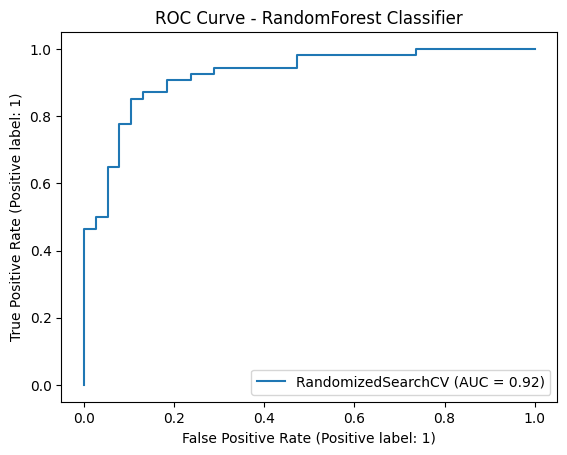

Confusion Matrix - RandomForest Classifier:
[[30  8]
 [ 5 49]]
Classification Report - RandomForest Classifier:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        38
           1       0.86      0.91      0.88        54

    accuracy                           0.86        92
   macro avg       0.86      0.85      0.85        92
weighted avg       0.86      0.86      0.86        92

Precision - RandomForest Classifier: 0.8596491228070176
Recall - RandomForest Classifier: 0.9074074074074074
F1 Score - RandomForest Classifier: 0.8828828828828829


In [32]:
# Evaluate RandomForest Classifier
disp_rfc = RocCurveDisplay.from_estimator(rs_rfc, x_test, y_test)
plt.title("ROC Curve - RandomForest Classifier")
plt.show()

y_pred_rfc = rs_rfc.predict(x_test)
print("Confusion Matrix - RandomForest Classifier:")
print(confusion_matrix(y_test, y_pred_rfc))
print("Classification Report - RandomForest Classifier:")
print(classification_report(y_test, y_pred_rfc))
print("Precision - RandomForest Classifier:", precision_score(y_test, y_pred_rfc))
print("Recall - RandomForest Classifier:", recall_score(y_test, y_pred_rfc))
print("F1 Score - RandomForest Classifier:", f1_score(y_test, y_pred_rfc))

In [33]:
best_params = rs_rfc.best_params_
best_score = rs_rfc.best_score_

In [35]:
print(best_score)

0.8789193136181087
